# Satellite-to-Ground Quantum Key Distribution Simulation (BB84)

KANAK
Tools: Python, NumPy, Matplotlib  

This project implements the BB84 quantum key distribution protocol and extends it to a satellite-to-ground free-space communication model incorporating atmospheric noise and photon loss.



## Background
The BB84 protocol uses two conjugate bases (Z and X) to securely distribute a cryptographic key using quantum states.

Security is evaluated using the Quantum Bit Error Rate (QBER), which measures disagreement between sender and receiver after basis reconciliation.



In [25]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)


## Quantum State Representation

Qubits are represented as 2D state vectors:

- |0⟩ = [1, 0]
- |1⟩ = [0, 1]
- |+⟩ = (|0⟩ + |1⟩)/√2
- |−⟩ = (|0⟩ − |1⟩)/√2


In [26]:
# Computational (Z) basis
zero = np.array([1, 0])
one = np.array([0, 1])

# Hadamard (X) basis
plus = (1/np.sqrt(2)) * np.array([1, 1])
minus = (1/np.sqrt(2)) * np.array([1, -1])


### Measurement Model (Born Rule)

Measurement probability is computed using:

P = |⟨φ|ψ⟩|²

This simulates projective quantum measurement.


In [27]:
def measure(state, basis):
    """
    state: quantum state vector (numpy array)
    basis: list containing two orthonormal basis vectors
    """

    # Compute probabilities
    p0 = np.abs(np.dot(basis[0], state))**2
    p1 = np.abs(np.dot(basis[1], state))**2

    # Normalize (just in case of numerical issues)
    probs = np.array([p0, p1])
    probs = probs / np.sum(probs)

    # Randomly choose outcome
    outcome = np.random.choice([0, 1], p=probs)

    return outcome


In [28]:
# Test: measuring |0> in Z basis should always give 0
z_basis = [zero, one]

results = [measure(zero, z_basis) for _ in range(1000)]
print("Average outcome measuring |0> in Z basis:", np.mean(results))



Average outcome measuring |0> in Z basis: 0.0


In [29]:
# Test: measuring |+> in Z basis should give 0 or 1 with ~50% probability
results = [measure(plus, z_basis) for _ in range(10000)]
print("Average outcome measuring |+> in Z basis:", np.mean(results))


Average outcome measuring |+> in Z basis: 0.4938


# BB84 Protocol Implementation

Simulation steps:
1. Alice prepares random bit in random basis.
2. Bob measures in random basis.
3. Basis reconciliation is performed.
4. QBER is computed.


In [30]:
def bb84_simulation(N):

    z_basis = [zero, one]
    x_basis = [plus, minus]

    alice_bits = []
    alice_bases = []
    bob_bases = []
    bob_results = []

    for _ in range(N):

        # Alice chooses random bit and basis
        bit = np.random.choice([0, 1])
        basis_choice = np.random.choice(['Z', 'X'])

        alice_bits.append(bit)
        alice_bases.append(basis_choice)

        # Prepare state
        if basis_choice == 'Z':
            state = zero if bit == 0 else one
        else:
            state = plus if bit == 0 else minus

        # Bob chooses random basis
        bob_basis_choice = np.random.choice(['Z', 'X'])
        bob_bases.append(bob_basis_choice)

        # Bob measures
        if bob_basis_choice == 'Z':
            result = measure(state, z_basis)
        else:
            result = measure(state, x_basis)

        bob_results.append(result)

    # Sifting step
    sifted_alice = []
    sifted_bob = []

    for i in range(N):
        if alice_bases[i] == bob_bases[i]:
            sifted_alice.append(alice_bits[i])
            sifted_bob.append(bob_results[i])

    sifted_alice = np.array(sifted_alice)
    sifted_bob = np.array(sifted_bob)

    # Compute QBER
    errors = np.sum(sifted_alice != sifted_bob)
    qber = errors / len(sifted_alice) if len(sifted_alice) > 0 else 0

    return qber


In [31]:
qber = bb84_simulation(10000)
print("QBER (No Eve):", qber)


QBER (No Eve): 0.0


## Intercept-Resend Attack Simulation

An eavesdropper (Eve) measures each photon in a random basis and resends the collapsed state.
This introduces ~25% disturbance in the sifted key.


In [32]:
def bb84_with_eve(N):

    z_basis = [zero, one]
    x_basis = [plus, minus]

    alice_bits = []
    alice_bases = []
    bob_bases = []
    bob_results = []

    for _ in range(N):

        # Alice chooses bit and basis
        bit = np.random.choice([0, 1])
        basis_choice = np.random.choice(['Z', 'X'])

        alice_bits.append(bit)
        alice_bases.append(basis_choice)

        # Prepare state
        if basis_choice == 'Z':
            state = zero if bit == 0 else one
        else:
            state = plus if bit == 0 else minus

        # --- Eve intercepts ---
        eve_basis_choice = np.random.choice(['Z', 'X'])

        if eve_basis_choice == 'Z':
            eve_result = measure(state, z_basis)
            state = zero if eve_result == 0 else one
        else:
            eve_result = measure(state, x_basis)
            state = plus if eve_result == 0 else minus

        # --- Bob receives and measures ---
        bob_basis_choice = np.random.choice(['Z', 'X'])
        bob_bases.append(bob_basis_choice)

        if bob_basis_choice == 'Z':
            result = measure(state, z_basis)
        else:
            result = measure(state, x_basis)

        bob_results.append(result)

    # Sifting
    sifted_alice = []
    sifted_bob = []

    for i in range(N):
        if alice_bases[i] == bob_bases[i]:
            sifted_alice.append(alice_bits[i])
            sifted_bob.append(bob_results[i])

    sifted_alice = np.array(sifted_alice)
    sifted_bob = np.array(sifted_bob)

    errors = np.sum(sifted_alice != sifted_bob)
    qber = errors / len(sifted_alice) if len(sifted_alice) > 0 else 0

    return qber


In [33]:
qber_eve = bb84_with_eve(20000)
print("QBER (With Eve):", qber_eve)


QBER (With Eve): 0.25188716726261423


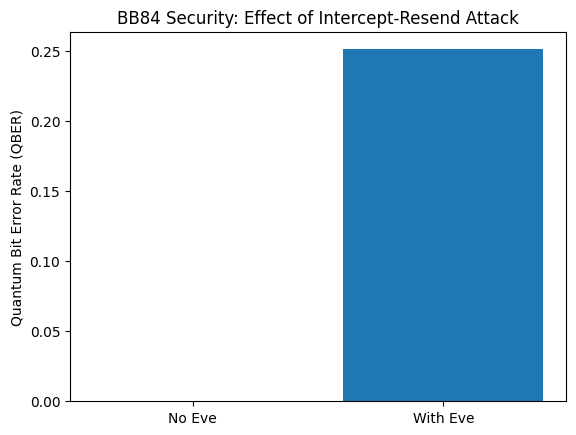

QBER (No Eve): 0.0
QBER (With Eve): 0.250990099009901


In [34]:
N = 20000

qber_no_eve = bb84_simulation(N)
qber_eve = bb84_with_eve(N)

plt.figure()
plt.bar(["No Eve", "With Eve"], [qber_no_eve, qber_eve])
plt.ylabel("Quantum Bit Error Rate (QBER)")
plt.title("BB84 Security: Effect of Intercept-Resend Attack")
plt.show()

print("QBER (No Eve):", qber_no_eve)
print("QBER (With Eve):", qber_eve)


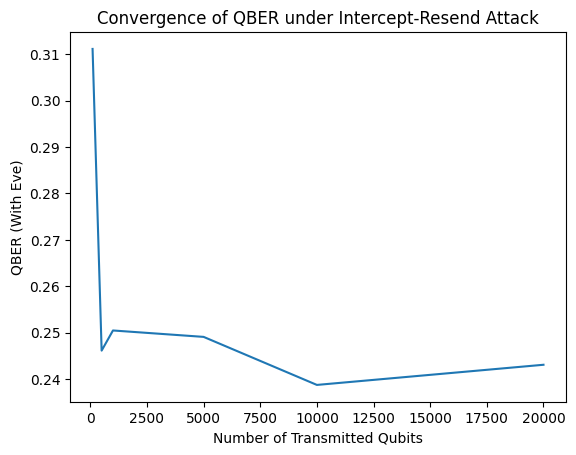

In [35]:
Ns = [100, 500, 1000, 5000, 10000, 20000]
qber_values = []

for n in Ns:
    qber_values.append(bb84_with_eve(n))

plt.figure()
plt.plot(Ns, qber_values)
plt.xlabel("Number of Transmitted Qubits")
plt.ylabel("QBER (With Eve)")
plt.title("Convergence of QBER under Intercept-Resend Attack")
plt.show()


In BB84, Eve measures each qubit in a randomly chosen basis.
She chooses the wrong basis with probability 1/2.

When she measures in the wrong basis, she collapses the state randomly, introducing a 50% error probability in those cases.

Therefore:

QBER = (1/2) × (1/2) = 25%

This simulation confirms this theoretical prediction.

In [36]:
def bb84_with_noise(N, noise_prob=0.0):

    z_basis = [zero, one]
    x_basis = [plus, minus]

    alice_bits = []
    alice_bases = []
    bob_bases = []
    bob_results = []

    for _ in range(N):

        bit = np.random.choice([0, 1])
        basis_choice = np.random.choice(['Z', 'X'])

        alice_bits.append(bit)
        alice_bases.append(basis_choice)

        if basis_choice == 'Z':
            state = zero if bit == 0 else one
        else:
            state = plus if bit == 0 else minus

        bob_basis_choice = np.random.choice(['Z', 'X'])
        bob_bases.append(bob_basis_choice)

        if bob_basis_choice == 'Z':
            result = measure(state, z_basis)
        else:
            result = measure(state, x_basis)

        # Channel noise: flip result with probability noise_prob
        if np.random.rand() < noise_prob:
            result = 1 - result

        bob_results.append(result)

    sifted_alice = []
    sifted_bob = []

    for i in range(N):
        if alice_bases[i] == bob_bases[i]:
            sifted_alice.append(alice_bits[i])
            sifted_bob.append(bob_results[i])

    sifted_alice = np.array(sifted_alice)
    sifted_bob = np.array(sifted_bob)

    errors = np.sum(sifted_alice != sifted_bob)
    qber = errors / len(sifted_alice) if len(sifted_alice) > 0 else 0

    return qber


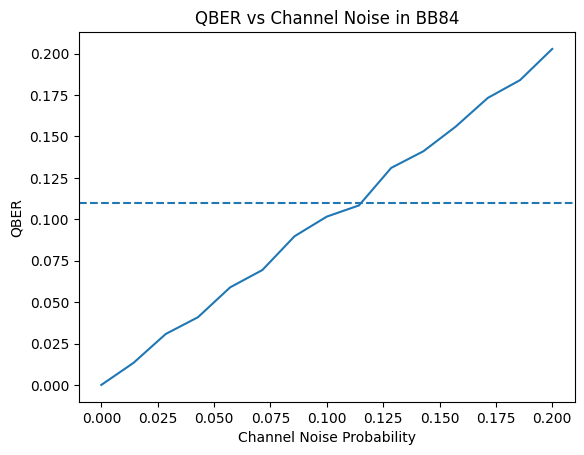

In [37]:
noise_values = np.linspace(0, 0.2, 15)
qber_values = []

for p in noise_values:
    qber_values.append(bb84_with_noise(20000, noise_prob=p))

plt.figure()
plt.plot(noise_values, qber_values)
plt.axhline(0.11, linestyle='--')  # security threshold
plt.xlabel("Channel Noise Probability")
plt.ylabel("QBER")
plt.title("QBER vs Channel Noise in BB84")
plt.show()


In [38]:
def visualize_bb84_rounds(N=20):

    z_basis = [zero, one]
    x_basis = [plus, minus]

    print("Idx | Alice Bit | Alice Basis | Bob Basis | Bob Result | Keep?")
    print("-"*70)

    for i in range(N):

        bit = np.random.choice([0, 1])
        alice_basis = np.random.choice(['Z', 'X'])

        # Prepare state
        if alice_basis == 'Z':
            state = zero if bit == 0 else one
        else:
            state = plus if bit == 0 else minus

        bob_basis = np.random.choice(['Z', 'X'])

        if bob_basis == 'Z':
            result = measure(state, z_basis)
        else:
            result = measure(state, x_basis)

        keep = "YES" if alice_basis == bob_basis else "NO"

        print(f"{i:3} |     {bit}      |      {alice_basis}       |     {bob_basis}     |     {result}      |  {keep}")


In [39]:
visualize_bb84_rounds(20)


Idx | Alice Bit | Alice Basis | Bob Basis | Bob Result | Keep?
----------------------------------------------------------------------
  0 |     1      |      X       |     X     |     1      |  YES
  1 |     0      |      Z       |     X     |     0      |  NO
  2 |     1      |      Z       |     X     |     0      |  NO
  3 |     1      |      X       |     X     |     1      |  YES
  4 |     1      |      Z       |     X     |     0      |  NO
  5 |     1      |      X       |     Z     |     0      |  NO
  6 |     0      |      X       |     Z     |     0      |  NO
  7 |     1      |      X       |     X     |     1      |  YES
  8 |     1      |      Z       |     X     |     1      |  NO
  9 |     1      |      Z       |     Z     |     1      |  YES
 10 |     1      |      Z       |     X     |     0      |  NO
 11 |     0      |      X       |     X     |     0      |  YES
 12 |     1      |      Z       |     Z     |     1      |  YES
 13 |     1      |      Z       |     Z  

In [40]:
def visualize_photons(N=20):

    angles = []
    colors = []

    for _ in range(N):
        bit = np.random.choice([0, 1])
        basis = np.random.choice(['Z', 'X'])

        if basis == 'Z':
            angle = 0 if bit == 0 else 90
        else:
            angle = 45 if bit == 0 else 135

        angles.append(np.deg2rad(angle))
        colors.append('blue' if basis == 'Z' else 'orange')

    plt.figure(figsize=(6,6))

    for i, theta in enumerate(angles):
        x = np.cos(theta)
        y = np.sin(theta)
        plt.arrow(0, 0, x, y,
                  head_width=0.05,
                  length_includes_head=True,
                  color=colors[i],
                  alpha=0.6)

    circle = plt.Circle((0, 0), 1, fill=False)
    plt.gca().add_patch(circle)

    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    plt.gca().set_aspect('equal', 'box')
    plt.title("Photon Polarizations (Z = Blue, X = Orange)")
    plt.show()


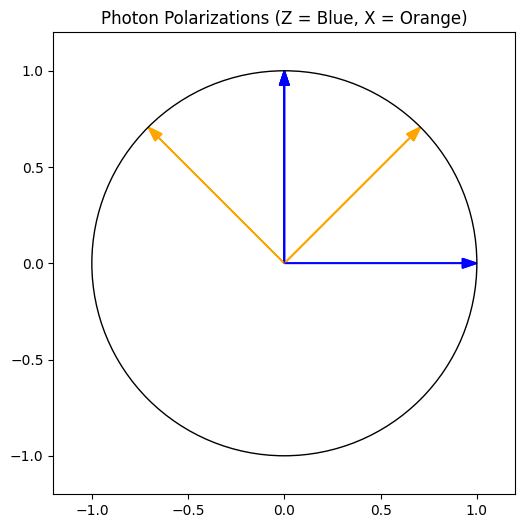

In [41]:
visualize_photons(20)


## Satellite-to-Ground Channel Model

To simulate realistic space-based communication, we include:

- Photon loss (transmission efficiency η)
- Atmospheric turbulence (bit-flip probability)
- Detector noise (dark counts)

We analyze QBER and secure key rate under these imperfections.


In [42]:
def satellite_bb84(N, eta=0.8, p_turb=0.02, p_dark=0.01):

    z_basis = [zero, one]
    x_basis = [plus, minus]

    sifted_alice = []
    sifted_bob = []

    for _ in range(N):

        # Alice chooses bit and basis
        bit = np.random.choice([0, 1])
        basis_choice = np.random.choice(['Z', 'X'])

        if basis_choice == 'Z':
            state = zero if bit == 0 else one
        else:
            state = plus if bit == 0 else minus

        # --- Photon loss (space channel attenuation) ---
        if np.random.rand() > eta:
            continue   # photon lost

        # Bob chooses basis
        bob_basis_choice = np.random.choice(['Z', 'X'])

        if bob_basis_choice == 'Z':
            result = measure(state, z_basis)
        else:
            result = measure(state, x_basis)

        # --- Atmospheric turbulence ---
        if np.random.rand() < p_turb:
            result = 1 - result

        # --- Detector dark counts ---
        if np.random.rand() < p_dark:
            result = np.random.choice([0, 1])

        if basis_choice == bob_basis_choice:
            sifted_alice.append(bit)
            sifted_bob.append(result)

    if len(sifted_alice) == 0:
        return 0, 0

    sifted_alice = np.array(sifted_alice)
    sifted_bob = np.array(sifted_bob)

    errors = np.sum(sifted_alice != sifted_bob)
    qber = errors / len(sifted_alice)

    key_rate = len(sifted_alice) / N

    return qber, key_rate


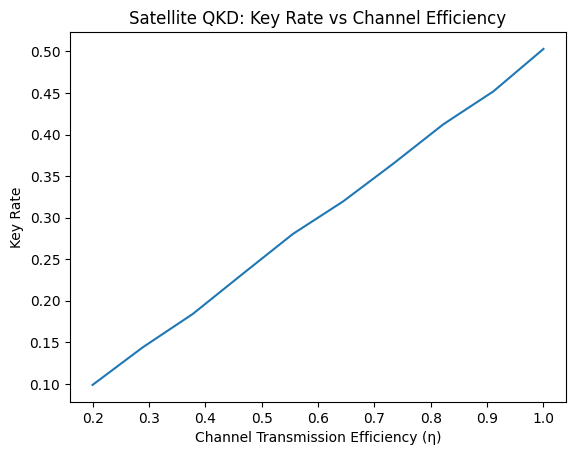

In [43]:
etas = np.linspace(0.2, 1.0, 10)
qbers = []
key_rates = []

for e in etas:
    q, r = satellite_bb84(20000, eta=e, p_turb=0.02, p_dark=0.01)
    qbers.append(q)
    key_rates.append(r)

plt.figure()
plt.plot(etas, key_rates)
plt.xlabel("Channel Transmission Efficiency (η)")
plt.ylabel("Key Rate")
plt.title("Satellite QKD: Key Rate vs Channel Efficiency")
plt.show()


In [44]:
from IPython.display import HTML

def animate_satellite_qkd(frames=100, eta=0.8, p_turb=0.05):

    fig, ax = plt.subplots(figsize=(5,8))

    ax.set_xlim(-1, 1)
    ax.set_ylim(0, 10)

    photons = []

    def update(frame):
        ax.clear()
        ax.set_xlim(-1, 1)
        ax.set_ylim(0, 10)

        ax.text(0, 9.5, "Satellite", ha='center', fontsize=12)
        ax.text(0, 0.3, "Ground Station", ha='center', fontsize=12)

        # generate new photon
        if np.random.rand() < 0.6:
            x = np.random.uniform(-0.5, 0.5)
            photons.append([x, 9])

        new_photons = []

        for photon in photons:
            photon[1] -= 0.25  # move downward

            if photon[1] <= 0:
                continue

            # photon loss
            if np.random.rand() > eta:
                continue

            # turbulence
            color = "green"
            if np.random.rand() < p_turb:
                color = "red"

            ax.scatter(photon[0], photon[1], c=color, s=40)
            new_photons.append(photon)

        photons[:] = new_photons

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=100)

    return HTML(ani.to_jshtml())


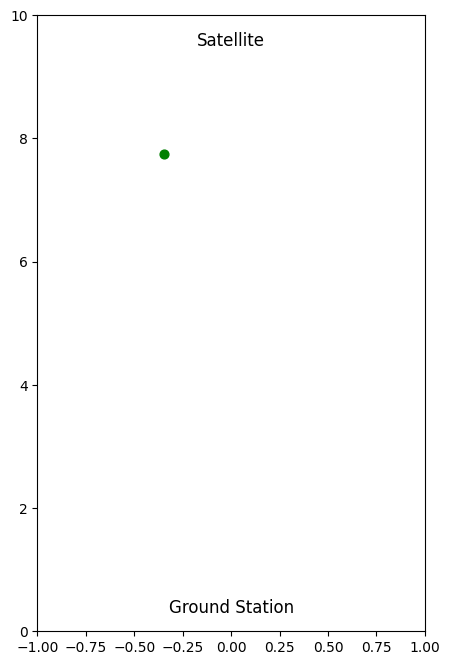

In [45]:
animate_satellite_qkd(frames=150, eta=0.8, p_turb=0.05)



## Results Summary

- Ideal channel → QBER ≈ 0
- Intercept-resend attack → QBER ≈ 25%
- Increased turbulence → higher QBER
- Reduced transmission efficiency → lower key rate

This demonstrates how quantum communication security depends on channel integrity in space-based optical links.
